In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def bgr_to_rgb(bgr):
    """
    Converts Blue, Green, Red to Red, Green, Blue
    """
    return bgr[..., [2, 1, 0]]

## Training Data Procurement

This notebook shows how to obtain raw data (Sentinel 2 satellite images) using Sentinel Hub and ground truth (polygons of tulip fields) from Geopedia.

###### Required WMS instance

Put your instance id in the next cell.

In [42]:
WMS_INSTANCE = ''
WMS_INSTANCE = "b1062c36-3d9a-4df5-ad3d-ab0d40ae3ca0"

In [43]:
sentinel_hub_wms='https://services.sentinel-hub.com/ogc/wms/'+WMS_INSTANCE

In [44]:
layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905', 'arable_land_2017':'ttl1917'}

In [7]:
from ipyleaflet import Map, WMSLayer

## Interactive display

Create map and center it around Den Helder, Netherlands. You can zoom in/out and change the view using your mouse. 

In [8]:
zoom_level = 13

In [9]:
import math
earth_radius = 6372.7982e3
pixel_size = 2* math.pi * earth_radius * math.cos(math.radians(52.9))/2**(zoom_level+8)
print('Pixel dimension at zoom level %d equals %1.2f m.'%(zoom_level,pixel_size))

Pixel dimension at zoom level 13 equals 11.52 m.


In [54]:
m = Map(center=[52.9255665659715, 4.754333496093751], zoom=zoom_level, layout=dict(width='512px', height='512px')); m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[52.9255665659715, 4.754333496093751], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']),), layout=Layout(height='512px', width='512px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=13)

#### Add Sentinel 2 layer to the map

In [45]:
s2_layer = WMSLayer(url='https://services.sentinel-hub.com/v1/wms/'+WMS_INSTANCE, layers='TRUE_COLOR', tile_size=512)

In [46]:
m.add_layer(s2_layer)

#### Add ground truth layer (all tulip fields from 2016)

In [47]:
tulips = WMSLayer(url='http://service.geopedia.world/wms/ml_aws', layers=layers['tulip_field_2017'], tile_size=512, format='image/png', version='1.3.0', TRANSPARENT=True, opacity=0.4)

In [48]:
m.add_layer(tulips)

In [15]:
m.remove_layer(tulips)

#### Define utilitiy function for converting points between two coordinate systems

In [29]:
import pyproj

In [49]:
def to_epsg3857(latlong_wgs84):
    epsg3857 = pyproj.Proj(init='epsg:3857')
    wgs84    = pyproj.Proj(init='EPSG:4326')
    return pyproj.transform(wgs84,epsg3857,latlong_wgs84[1],latlong_wgs84[0])

## Download patches

In [50]:
bbox_3857 = [to_epsg3857(point) for point in m.bounds]; 

In [32]:
import sys

Set path to directory containing DataRequest

In [33]:
PATH = './DataRequest'
sys.path.append(PATH)

In [34]:
from DataRequest import TulipFieldRequest

### Download truth mask

In [51]:
tulipFields = TulipFieldRequest(bbox=bbox_3857,width=512,height=512,crs=3857,layer=layers['tulip_field_2016'])

In [52]:
tulip_field = tulipFields.get_data()

Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=512&width=512&srs=EPSG:3857&bbox=523673.9017000867,6956598.915591299,543241.7809410939,6966382.855211801


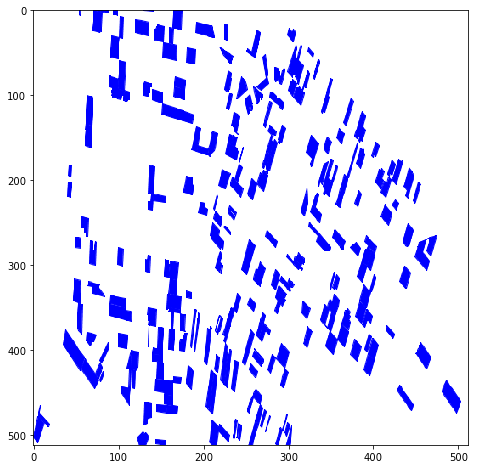

In [53]:
plt.figure(figsize=(8,8))
plt.imshow(tulip_field[0])